# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
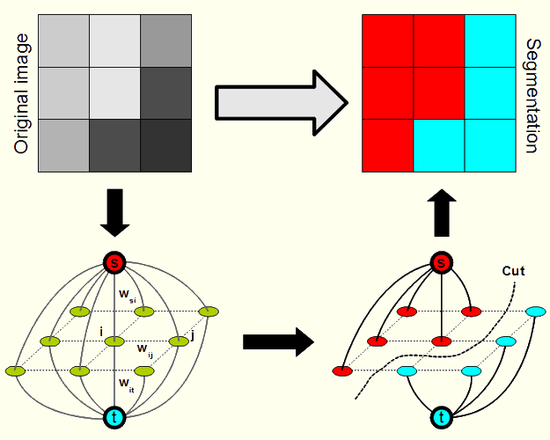

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2
from collections import namedtuple
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import igraph as ig
import logging
import sys
from tqdm.auto import tqdm as tq

RAND_SEED = 42
# np.random.seed(RAND_SEED)
con = namedtuple('_', ('FIX', 'UNK', 'FG', 'BG'))(1, 0, 1, 0)

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [3]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _types, _alphas, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._types = _types
        self._alphas = _alphas
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def types(self):
        return self._types

    @types.setter
    def types(self, _types):
        self._types = _types
    
    @property
    def alphas(self):
        return self._alphas

    @alphas.setter
    def alphas(self, _alphas):
        self._alphas = _alphas
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

                # initialise types and alphas
                temp = np.zeros(self._types.shape, dtype=np.uint8)
                rect = self.FLAGS['RECT']
                temp[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = 1
                self._types[temp == 0] = con.FIX
                self._alphas[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = con.FG

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            # if self.FLAGS['rect_over'] == False:
            #     print('Draw the rectangle first.')
            # else:
            if self.FLAGS['rect_over'] == True:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._alphas, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._types, (x,y), 3, con.FIX, -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._alphas, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._types, (x,y), 3, con.FIX, -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._alphas, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._types, (x,y), 3, con.FIX, -1)

In [4]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : con.BG}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : con.FG}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    types = np.zeros(img.shape[:2], dtype = np.uint8)  # everything unknown and background initially
    alphas = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                       #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)             # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, types, alphas, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        types = EventObj.types
        alphas = EventObj.alphas
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            types = np.zeros(img.shape[:2], dtype = np.uint8) 
            alphas = np.zeros(img.shape[:2], dtype = np.uint8)
            EventObj.image = img
            EventObj.types = types
            EventObj.alphas = alphas
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            alphas = grab_cut(img2, types, alphas)
            # FLAGS['rect'] = None
            # plt.imshow(mask)
            # plt.show()
            EventObj.alphas = alphas

        
        EventObj.flags = FLAGS
        mask2 = np.where((alphas == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

In [5]:

NUM_GMM_COMP = 5
GAMMA = 50
LAMDA = 9 * GAMMA
NUM_ITERS = 5
TOL = 1

In [6]:
def fit_gmms(img, alphas, n_components=NUM_GMM_COMP):
    fg = GaussianMixture(n_components=n_components)
    fg.fit(img[alphas == con.FG])

    bg = GaussianMixture(n_components=n_components)
    bg.fit(img[alphas == con.BG])

    return fg, bg

def graph_cut(img, types, alphas, fg_gmm, bg_gmm, beta, gamma, lamda):
    logging.debug('GRAPH CUT')
    # we don't use alphas here, except for known seeds
    # because this step is to compute new alphas for the unknown regions
    
    # CLOSURE FUNCTIONS FOR CAPACITY AND ENERGIES
    fg_D = - fg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])
    bg_D = - bg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])
    # def compute_D(i, j):
    #     sample = img[i, j].reshape((1, -1))
        
    #     # foreground
    #     fg_log_pr = fg_gmm.score_samples(sample)[0]
    #     # fg_label = fg_gmm.predict(sample)[0]
    #     # fg_log_wt = np.log(fg_gmm.weights_[fg_label])
    #     fg_D = - fg_log_pr # - fg_log_wt

    #     # background
    #     bg_log_pr = bg_gmm.score_samples(sample)[0]
    #     # bg_label = bg_gmm.predict(sample)[0]
    #     # bg_log_wt = np.log(bg_gmm.weights_[bg_label])
    #     bg_D = - bg_log_pr # - bg_log_wt

    #     return fg_D, bg_D

    def compute_V(i, j, oi, oj):
        # if alphas[i, j] == alphas[oi, oj]:
        #     return 0

        return np.exp(- beta * (np.linalg.norm(img[i, j] - img[oi, oj]) ** 2))

    # COMPUTE KNOWN EDGE CAPACITY
    logging.debug('CALC fix_cap')
    fix_cap = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            cap_sum = 0
            if i > 0:
                cap_sum += compute_V(i, j, i-1, j)
            if j > 0:
                cap_sum += compute_V(i, j, i, j-1)
            if i < img.shape[0] - 1:
                cap_sum += compute_V(i, j, i+1, j)
            if j < img.shape[1] - 1:
                cap_sum += compute_V(i, j, i, j+1)
            fix_cap = max(fix_cap, 1 + cap_sum)

    # BUILD GRAPH
    logging.debug('BUILD GRAPH')
    num_pix = img.shape[0] * img.shape[1]
    # the last two vertices are S and T respectively

    def vid(i, j): # vertex ID
        return (img.shape[1] * i) + j

    def ind(idx): # image index
        return ((idx // img.shape[1]), (idx % img.shape[1]))
    
    graph = ig.Graph(directed=False)
    graph.add_vertices(num_pix + 2)
    S = num_pix
    T = num_pix+1

    edges = []
    weights = []
    for i in tq(range(img.shape[0]), leave=False, position=0, disable=True):
        for j in tq(range(img.shape[1]), leave=False, position=1, disable=True):

            # add edges to S and T
            if types[i, j] == con.FIX:
                if alphas[i, j] == con.FG:
                    edges.append((vid(i, j), S))
                    weights.append(fix_cap)
                else:
                    edges.append((vid(i, j), T))
                    weights.append(fix_cap)
            else:
                # fg_D, bg_D = compute_D(i, j)
                
                edges.append((vid(i, j), S))
                weights.append(lamda * bg_D[i, j])

                edges.append((vid(i, j), T))
                weights.append(lamda * fg_D[i, j])
            
            # add edges to neighbours
            if i > 0:
                oi = i-1
                oj = j
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))
            
            if j > 0:
                oi = i
                oj = j-1 
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))
    
    # [print(type(x)) for x in weights]
    graph.add_edges(edges, attributes={'weight': weights})
    ig.summary(graph)
    logging.debug('MINCUT')
    #flow, bg_vertices, fg_vertices, _ = 
    cut = graph.st_mincut(S, T, capacity='weight')
    bg_vertices = cut.partition[0]
    fg_vertices = cut.partition[1]
    if S in bg_vertices:
        bg_vertices, fg_vertices = fg_vertices, bg_vertices
    
    new_alphas = np.zeros(img.shape[:2], dtype=np.uint8) # con.BG is filled, zeroes is faster
    for v in fg_vertices:
        if v not in (S, T):
            new_alphas[ind(v)] = 1
    return cut.value, new_alphas


def grab_cut(img_, types_, alphas_, gamma=GAMMA, lamda=LAMDA, num_iters=NUM_ITERS, tol=TOL):
    # print(rect)
    logging.debug('GRAB CUT')
    img = img_.copy().astype(np.float32)
    types = types_.copy()
    alphas = alphas_.copy()
    
    # types tells whether the pixel is fixed or unknown
    # types = np.where((mask_ != 0), con.FIX, con.UNK).astype(np.uint8)
    # if rect:
    #     temp = np.zeros(types.shape, dtype=np.uint8)
    #     temp[rect[1]:rect[3], rect[0]:rect[2]] = 1
    #     types[temp == 0] = con.FIX
    
    # alphas tells whether the pixel is fg or bg according to fixed or current estimate
    # alphas = np.zeros(img.shape[:2], dtype=np.uint8) # con.BG is filled, zeroes is faster
    # if rect:
    #     alphas[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = con.FG
    # alphas[mask_ == 1] = con.FG
    # alphas[mask_ == 2] = con.BG
    plt.imshow(alphas)
    plt.show()
    plt.imshow(types)
    plt.show()
    # calculate beta
    logging.debug('CALC BETA')
    beta = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i > 0:
                beta += img[i, j].dot(img[i-1, j])
            if j > 0:
                beta += img[i, j].dot(img[i, j-1])
    beta /= (4 * img.shape[0] * img.shape[1] - 3 * img.shape[0] - 3 * img.shape[1] + 2)
    beta *= 2
    beta = 1 / beta
    print('beta', beta)
    prev_flow = -1
    for _ in range(num_iters):
        logging.debug(f'\nITER {_}\nCALC GMM')
        fg_gmm, bg_gmm = fit_gmms(img, alphas)
        flow, alphas = graph_cut(img, types, alphas, fg_gmm, bg_gmm, beta, gamma, lamda)
        plt.imshow(alphas)
        plt.show()
        if prev_flow != -1 and abs(prev_flow - flow) < tol:
            break
        
        prev_flow = flow
    
    # alphas[mask_ == 2] = 2
    logging.debug('DONE')
    return alphas



sed.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Universalis ADF Std' (UniversalisADFStd-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntegralsD-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntegralsD-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'eufm10' (eufm10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman' (lmroman5-regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Bengali' (NotoSerifBengali-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont

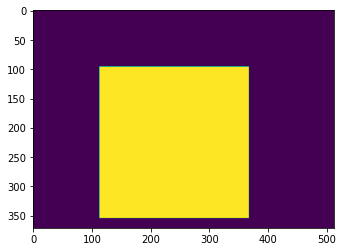

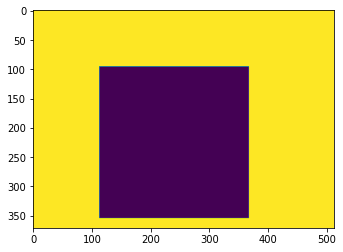

DEBUG:root:CALC BETA
beta 1.8941695461241988e-05
DEBUG:root:
ITER 0
CALC GMM
DEBUG:root:GRAPH CUT
DEBUG:root:CALC fix_cap
DEBUG:root:BUILD GRAPH
IGRAPH U-W- 190325 635875 -- 
+ attr: weight (e)
DEBUG:root:MINCUT


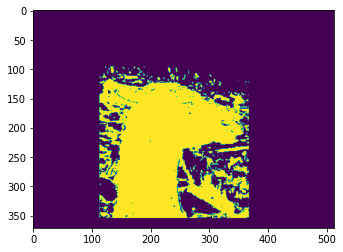

DEBUG:root:
ITER 1
CALC GMM
DEBUG:root:GRAPH CUT
DEBUG:root:CALC fix_cap
DEBUG:root:BUILD GRAPH
IGRAPH U-W- 190325 635875 -- 
+ attr: weight (e)
DEBUG:root:MINCUT


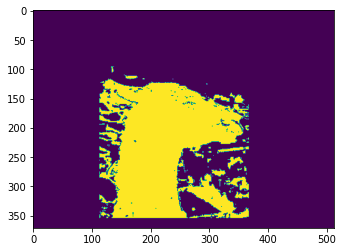

DEBUG:root:
ITER 2
CALC GMM
DEBUG:root:GRAPH CUT
DEBUG:root:CALC fix_cap
DEBUG:root:BUILD GRAPH
IGRAPH U-W- 190325 635875 -- 
+ attr: weight (e)
DEBUG:root:MINCUT


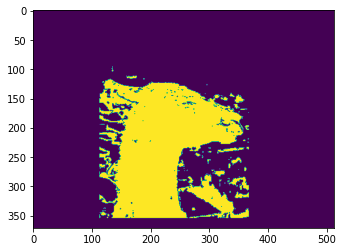

DEBUG:root:
ITER 3
CALC GMM
DEBUG:root:GRAPH CUT
DEBUG:root:CALC fix_cap
DEBUG:root:BUILD GRAPH
IGRAPH U-W- 190325 635875 -- 
+ attr: weight (e)
DEBUG:root:MINCUT


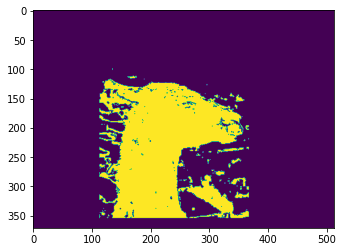

DEBUG:root:
ITER 4
CALC GMM
DEBUG:root:GRAPH CUT
DEBUG:root:CALC fix_cap
DEBUG:root:BUILD GRAPH
IGRAPH U-W- 190325 635875 -- 
+ attr: weight (e)
DEBUG:root:MINCUT


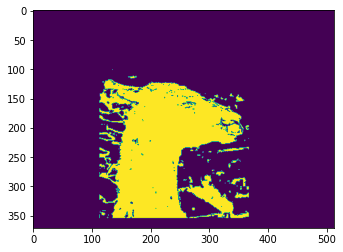

DEBUG:root:DONE


In [7]:
if __name__ == '__main__':
    filename = '../images/llama.jpg'              # Path to image file
    try:
        run(filename)
    finally:
        cv2.destroyAllWindows()